# Preamble
My second project is the Titanic example here. I will analyse the single feature in first place. Therefore its starts with a null-value analysis and the restoration of missing data. This includes the creation of new features as well. Right after that there will be a feature distribution as well as a survivor distribution to get a closer view on the dataset. I have tried a lot with Matplotlib to visualize several charts. Sometimes there were written a lot lines of code which I hided to not overload this notebook (feel free to fork). 
...

-------------
<b><h2 style="color:red;">!!! Development - State !!!</h2></b>
Right now this is a development state. Updates wil come as soon as possible. Stay tuned.


--------------


In [44]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sns


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'gender_submission.csv', 'test.csv']


# Import and Preparation

In [45]:
df_train = pd.read_csv('../input/train.csv', index_col='PassengerId')
df_test = pd.read_csv('../input/test.csv', index_col='PassengerId')
df_gender_sub = pd.read_csv("../input/gender_submission.csv", index_col='PassengerId')

In [46]:
# Storing the target separately
Survived = df_train.loc[:,'Survived']
df_train = df_train.drop(['Survived'], axis=1).copy()

# Saving index for train test split 
train_index = df_train.index
test_index = df_test.index

# Concate the two datasets
df_all = pd.concat([df_train, df_test])

# dont needed anymore
##del df_train
##del df_test

# Create new feature Family true/false
df_all.loc[:,'Family'] = ((df_all['SibSp'] > 0) | (df_all['Parch'] > 0)).replace(True, 1, inplace=False)
df_all.loc[:,'Family'] = df_all.loc[:,'Family'].astype(int)

# Missing Values

In [47]:
# Function for nullanalysis
def nullAnalysis(df):
    tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})

    tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
    tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
    return tab_info

In [48]:
# Show the null values
nullAnalysis(df_all)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family
column type,int64,object,object,float64,int64,int64,object,float64,object,object,int64
null values (nb),0,0,0,263,0,0,0,1,1014,2,0
null values (%),0,0,0,20.0917,0,0,0,0.0763942,77.4637,0.152788,0


## Age

In [49]:
# First 10 datarows where age is null
df_all[df_all.loc[:,'Age'].isnull()].head(10)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family
PassengerId,,,,,,,,,,,
6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0
18,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S,0
20,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C,0
27,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C,0
29,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q,0
30,3,"Todoroff, Mr. Lalio",male,NaN,0,0,349216,7.8958,NaN,S,0
32,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C,1
33,3,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q,0
37,3,"Mamee, Mr. Hanna",male,NaN,0,0,2677,7.2292,NaN,C,0


In [50]:
# Average age overall
print("Average age of a passengers: ", round(df_all.loc[:,'Age'].agg('mean'),0))

Average age of a passengers:  30.0


In [51]:
# Average age per class
df_all.groupby('Pclass')['Age'].agg('mean')

Pclass
1    39.159930
2    29.506705
3    24.816367
Name: Age, dtype: float64

We will use the average age of the corresponding class to fill the missing passenger ages. This would be the best fit for that problem.

In [52]:
# Setting the average age of each class for the missing values inside the corresponding class
df_all.loc[(df_all['Age'].isnull()) & (df_all['Pclass'] == 1), ['Age']] = round(df_all.groupby('Pclass')['Age'].agg('mean')[1],0)
df_all.loc[(df_all['Age'].isnull()) & (df_all['Pclass'] == 2), ['Age']] = round(df_all.groupby('Pclass')['Age'].agg('mean')[2],0)
df_all.loc[(df_all['Age'].isnull()) & (df_all['Pclass'] == 3), ['Age']] = round(df_all.groupby('Pclass')['Age'].agg('mean')[3],0)

## Fare


In [53]:
df_all[df_all['Fare'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family
PassengerId,,,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,0


One passenger has not payed his Ticket, or is even not recorded. To fill the gab I will use the mean ticket price for his third class ticket: 13.30 

In [54]:
df_all.groupby('Pclass', as_index=False)['Fare'].agg('mean')

,Pclass,Fare
0,1,87.508992
1,2,21.179196
2,3,13.302889


In [55]:
# Setting Fare to mean fare of pclass
df_all.loc[1044,['Fare']] = 13.30

## Cabin

In [56]:
# Show all Cabins with NaN data
df_all.loc[(df_all['Cabin'].isnull())].count()

Pclass      1014
Name        1014
Sex         1014
Age         1014
SibSp       1014
Parch       1014
Ticket      1014
Fare        1014
Cabin          0
Embarked    1014
Family      1014
dtype: int64

The *Cabin* situation looks pretty bad. From the 1309 data points are only roundabout 300 filled with *Cabin* information, the other 1000 data points are empty. I assumed with the cabin information one could rather conclude on a passengers survival or not. I don't want to use the fillna() - method with this sparely filled feature, that would not make any sense and will probably affect my results badly.  Lets look into the *Cabin* distribution compared the the *Pclass*

In [57]:
# Group by Pclasses
df_all.groupby('Pclass').agg('count')[['Name','Cabin']]

,Name,Cabin
Pclass,,
1,323,256
2,277,23
3,709,16


The round about 300 filled examples for the *Cabin* information are fairly one-sided distributed to the first class (*Pclass*). The *Name* shows the total distribution for the cabin class, so 256 passengers of 323 first class passengers have a *Cabin* information available. Only 39 *Cabin* values are filled in the second and third class (*Pclass*), they are divided up with 23 in second and 16 in third class. In comparision to the amount of passengers makes it not better, there are 709 passengers in the third class and 277 in second class. First class has 323 passengers in it's area. The completeness of the data in relation to the number of passengers per class is as follows:

In [58]:
(df_all.groupby('Pclass').agg('count')['Cabin'] / df_all.groupby('Pclass').agg('count')['Name'])*100

Pclass
1    79.256966
2     8.303249
3     2.256700
dtype: float64

It clearly shows that the second and third class are sparsely filled with in comparision to their passengers count. The first class in comparision looks with nearly 80% pretty good. One could consider applying the **fillNa** only to the first class and using a different method for the second and third class.

While analysing the *Cabin* feature I realize there are sometimes multiple values inside the *Cabin* feature. The following table shows you the multiple *Cabin* values:

In [59]:
df_all[df_all['Cabin'].str.contains(' ', regex=False) == True].sort_values(by='Cabin')

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family
PassengerId,,,,,,,,,,,
1235,1,"Cardeza, Mrs. James Warburton Martinez (Charlo...",female,58.00,0,1,PC 17755,512.3292,B51 B53 B55,C,1
873,1,"Carlsson, Mr. Frans Olof",male,33.00,0,0,695,5.0000,B51 B53 B55,S,0
680,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.00,0,1,PC 17755,512.3292,B51 B53 B55,C,1
1264,1,"Ismay, Mr. Joseph Bruce",male,49.00,0,0,112058,0.0000,B52 B54 B56,S,0
1034,1,"Ryerson, Mr. Arthur Larned",male,61.00,1,3,PC 17608,262.3750,B57 B59 B63 B66,C,1
956,1,"Ryerson, Master. John Borie",male,13.00,2,2,PC 17608,262.3750,B57 B59 B63 B66,C,1
916,1,"Ryerson, Mrs. Arthur Larned (Emily Maria Borie)",female,48.00,1,3,PC 17608,262.3750,B57 B59 B63 B66,C,1
312,1,"Ryerson, Miss. Emily Borie",female,18.00,2,2,PC 17608,262.3750,B57 B59 B63 B66,C,1
743,1,"Ryerson, Miss. Susan Parker ""Suzette""",female,21.00,2,2,PC 17608,262.3750,B57 B59 B63 B66,C,1


There is a way to split the string values easily but the information gain from the 41 examples in comparision to the round about 1000 missing values is pretty low:

In [60]:
# Creating a data frame for the Cabin values to split multiple values into seperate columns
df_cabin_expand = df_all.loc[:,'Cabin'].str.split(' ', expand=True)

# Group all doubled values by the first value
df_cabin_expand[df_cabin_expand.loc[:,1].isnull() == False].groupby([0]).count()

,1,2,3
0,,,
B51,3,3,0
B52,1,1,0
B57,5,5,5
B58,3,0,0
B82,1,0,0
B96,4,0,0
C22,4,0,0
C23,6,6,0
C55,2,0,0


The *Cabin* feature will be dropped at least. It there is no way of restoring the informaiton from this column, the duplicate values are not enough to restore all missing values and the other features to not supply enough information to restore this based of them.

## Salutation
With analyzing the *Cabin* feature I realized there exists different salutations in the passengers *Name* feature. The string split funciton will be usefull here, mentioned in the *Cabin* feature analysis. The values differ among others as follows:


In [61]:
# Split Name feature strings into several columns
df_name_salutation = df_all.loc[:,'Name'].str.split(' ', expand=True)
df_name_salutation.groupby(1).count()

,0,2,3,4,5,6,7,8,9,10,11,12,13
1,,,,,,,,,,,,,
"Billiard,",3,3,3,3,0,0,0,0,0,0,0,0,0
"Brito,",1,1,1,1,0,0,0,0,0,0,0,0,0
Capt.,1,1,1,0,0,0,0,0,0,0,0,0,0
"Carlo,",2,2,2,1,1,0,0,0,0,0,0,0,0
Col.,4,4,3,0,0,0,0,0,0,0,0,0,0
"Cruyssen,",1,1,1,0,0,0,0,0,0,0,0,0,0
Don.,1,1,1,0,0,0,0,0,0,0,0,0,0
Dr.,8,8,4,0,0,0,0,0,0,0,0,0,0
"Gordon,",2,2,2,2,2,2,1,0,0,0,0,0,0


Here is still something to clean but you can clearly see, that the most values in the split column "1" refers to the passengers salutation. Moreover I recognized that the salutations strings always ends with a dot.:

- Capt. - Captain
- Col. - Colonel
- Don. - Don
- Dr. - Doctor
- Major.
- Master. - "a way of addressing politely a boy ... too young to be called 'Mister'." - *Leslie Dunkling*  
- Miss. 
- Mlle. - Mademoiselle
- Mme. - Madame
- Mr.
- Mrs.
- Ms.
- Countess.
- ...

Next I will retriev the single salutations from column 1 and 2 based on the string value "." (dot) and concatenate the two columns to one salutation column and append these to the main dataframe. 

In [62]:
# Extract Salutation from every column based on the '.'
df_newsal_1 = df_name_salutation[df_name_salutation[1].str.contains('.', regex=False)][1]
df_newsal_2 = df_name_salutation[df_name_salutation[2].str.contains('.', regex=False)][2]
df_newsal_3 = df_name_salutation[(df_name_salutation[3].isnull() == False) & (df_name_salutation[3].str.contains('.', regex=False))][3]

# Rename column for append 
df_newsal_2 = df_newsal_2.rename(1)
df_newsal_3 =  df_newsal_3.rename(1)

# Append both salutations results to one column and rename them
df_newsal = df_newsal_1.append([df_newsal_2, df_newsal_3])
df_newsal = df_newsal.rename('Salutation')

# Concatenate them to the main dataframe
df_all = pd.concat([df_all,df_newsal],axis=1)

The following list shows all the salutation distribution. Nothing is leftover right now:

In [63]:
df_all.groupby('Salutation').count()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family
Salutation,,,,,,,,,,,
Capt.,1,1,1,1,1,1,1,1,1,1,1
Col.,4,4,4,4,4,4,4,4,3,4,4
Countess.,1,1,1,1,1,1,1,1,1,1,1
Don.,1,1,1,1,1,1,1,1,0,1,1
Dona.,1,1,1,1,1,1,1,1,1,1,1
Dr.,8,8,8,8,8,8,8,8,4,8,8
Jonkheer.,1,1,1,1,1,1,1,1,0,1,1
Lady.,1,1,1,1,1,1,1,1,1,1,1
Major.,2,2,2,2,2,2,2,2,2,2,2


## Embark
The *Embark* feature has two null values. For this small amount of missing values I will use the fillna-function to fill the gaps.

In [64]:
df_all[df_all['Embarked'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Salutation
PassengerId,,,,,,,,,,,,
62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,0,Miss.
830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,0,Mrs.


In [65]:
# Fill the two missing Embarked features by using the next valid value
df_all['Embarked'] = df_all['Embarked'].fillna(method='bfill')

# Feature Distribution

## Gender Distribution

In [66]:
# Gender distribution
df_all.groupby(['Parch']).agg('count')

,Pclass,Name,Sex,Age,SibSp,Ticket,Fare,Cabin,Embarked,Family,Salutation
Parch,,,,,,,,,,,
0,1002,1002,1002,1002,1002,1002,1002,205,1002,1002,1002
1,170,170,170,170,170,170,170,56,170,170,170
2,113,113,113,113,113,113,113,29,113,113,113
3,8,8,8,8,8,8,8,3,8,8,8
4,6,6,6,6,6,6,6,2,6,6,6
5,6,6,6,6,6,6,6,0,6,6,6
6,2,2,2,2,2,2,2,0,2,2,2
9,2,2,2,2,2,2,2,0,2,2,2


The feature **Cabin** seems to have some missing values.

## Gender Distribution by Ticket Class
Following will show the gender distribution by ticket class.

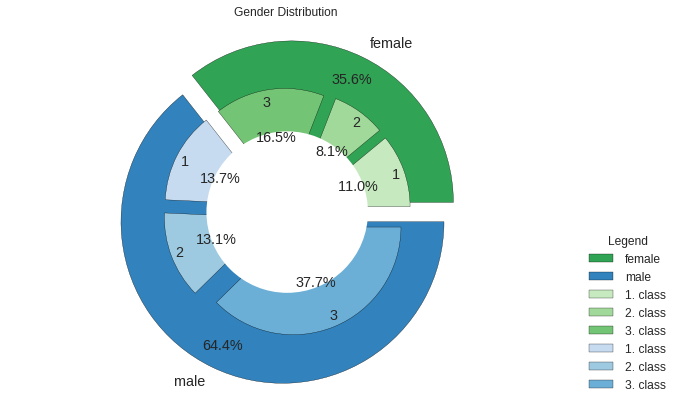

In [67]:
# Visualizing pie chart

fig, ax = plt.subplots(figsize=(10,7))

# Size and explsion
size_out = 3
size_in = 1
explode_out = (0.2,0.2)
explode_in = (0.3,0.3,0.3,0.3,0.3,0.3)

cmap = plt.get_cmap('tab20c')

outer_colors = cmap(np.array([8,0]))
inner_colors = cmap(np.array([11,10,9,3,2,1]))

patches1, texts1, autotexts1 = ax.pie(df_all.groupby(['Sex']).count().Name, radius=3, colors=outer_colors,
       labels=df_all.groupby(['Sex']).count().Name.index,autopct='%1.1f%%',pctdistance=0.85,
       wedgeprops=dict(width=size_out, edgecolor='black'),
       explode = explode_out)

patches2, texts2, autotexts2 = ax.pie(df_all.groupby(['Sex','Pclass']).count().Name, radius=2, colors=inner_colors,
       labels=[1,2,3,1,2,3],autopct='%1.1f%%', labeldistance=0.88,pctdistance=0.55,
       wedgeprops=dict(width=size_in, edgecolor='black'),
      explode = explode_in)

# Centre Cirle
centre_circle = plt.Circle((0,0),1.5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

#plt.rcParams['font.size'] = 10.0
#plt.rc_context


# Define the labels on the outer plot
for t in texts1:
    t.set_size('large')
for t in autotexts1:
    t.set_size('large')
#autotexts1[0].set_color('y')


# Define the labels on the inner plot
for t in texts2:
    t.set_size('large')
for t in autotexts2:
    t.set_size('large')
#autotexts2[0].set_color('d')


# Setting legend
ax.legend(loc='lower right', bbox_to_anchor=(0.7, 0., 0.5, 0.5), shadow=1,title='Legend',
          handletextpad=1, labelspacing=0.5 , fontsize='12', labels=['female','male','1. class','2. class', '3. class','1. class','2. class', '3. class'])


ax.set(aspect="equal", title='Gender Distribution')
plt.axis('equal')
plt.show()

Here you can see the diffrent gender distributions to the ticket classes 1 to 3.

## Age Distribution by Ticket Class
Now the age distribution per ticket class will be visualized to get a better overview about the ages in each ticket class.

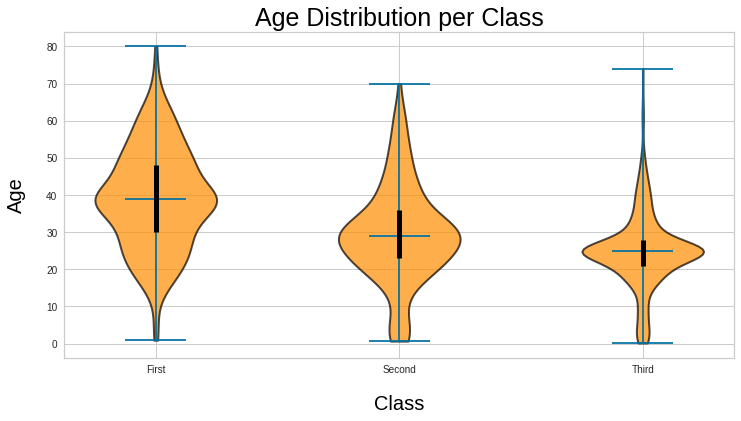

In [68]:
# Sclicing the three classes
df_firstclass_ages = df_all[df_all.loc[:,'Pclass'] == 1]['Age'].copy()
df_secondclass_ages = df_all[df_all.loc[:,'Pclass'] == 2]['Age'].copy()
df_thirdclass_ages = df_all[df_all.loc[:,'Pclass'] == 3]['Age'].copy()

# Combining all classes in an array
df_all_class_ages =[df_firstclass_ages.values,
                    df_secondclass_ages.values,
                    df_thirdclass_ages.values]

# Font dictionary
font = {'color':  'black',
        'weight': 'normal',
        'size': 18,
}

# Building the figure and the axes for the plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6) )

# plot violin plot
parts = axes.violinplot(df_all_class_ages
                   ,showmeans=False,
                    showmedians=True)
axes.set_title('Age Distribution per Class', fontdict=font, fontsize=25)

# Styling every violin in the graph
for pc in parts['bodies']:
    pc.set_facecolor('#FF8C00')
    pc.set_edgecolor('#000000')
    pc.set_linewidth(2)
    pc.set_alpha(0.7)


# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y + 1 for y in range(len(df_all_class_ages))])
axes.set_xlabel('Class',fontdict=font, labelpad=20, size=20)
axes.set_ylabel('Age', fontdict=font,labelpad=20, size=20)


axes.vlines(1, df_firstclass_ages.describe()['25%'], df_firstclass_ages.describe()['75%'], color=['#000000'], linestyle='-', lw=5)
axes.vlines(2, df_secondclass_ages.describe()['25%'], df_secondclass_ages.describe()['75%'], color=['#000000'], linestyle='-', lw=5)
axes.vlines(3, df_thirdclass_ages.describe()['25%'], df_thirdclass_ages.describe()['75%'], color=['#000000'], linestyle='-', lw=5)
#axes.vlines(2, whiskersMin, whiskersMax, color='k', linestyle='-', lw=1)

# add x-tick labels
plt.setp(axes, xticks=[y + 1 for y in range(len(df_all_class_ages))],
         xticklabels=['First', 'Second','Third'])


plt.show()

The first class has a wide range of passengers with a mean age of nearly 40. This looks different in the second class. The passengers have at least the same range of ages but the mean age here is more in the area of 30 years. The same is with third class but here is the age range not so high as with the other classes. Its even much smaller outside the mean age of 25. The most passengers in the third class are around 25 years old. 

## Salutation Distribution


In [69]:
df_all.groupby('Salutation').count()['Name']

Salutation
Capt.          1
Col.           4
Countess.      1
Don.           1
Dona.          1
Dr.            8
Jonkheer.      1
Lady.          1
Major.         2
Master.       61
Miss.        260
Mlle.          2
Mme.           1
Mr.          757
Mrs.         197
Ms.            2
Rev.           8
Sir.           1
Name: Name, dtype: int64

# Survivor Distribution
In this chapter we will focus on the survivor distribution. In comparision to the **Feature Distribution** we will only focus on the training dataset because we only  have falid survival information in this dataset. The training dataset only includes 891 and not 1309 as in the **Feature Distribution**, therefore the distribution will look here slightly different.


## Male and Female Survivor
According to the distribution of 64.5% man and 35.6% women, I will now show the distribution of survivors broken down by gender. This distribution only shows the survival data for 891 passengers (from training data) and not for all ship passengers.  


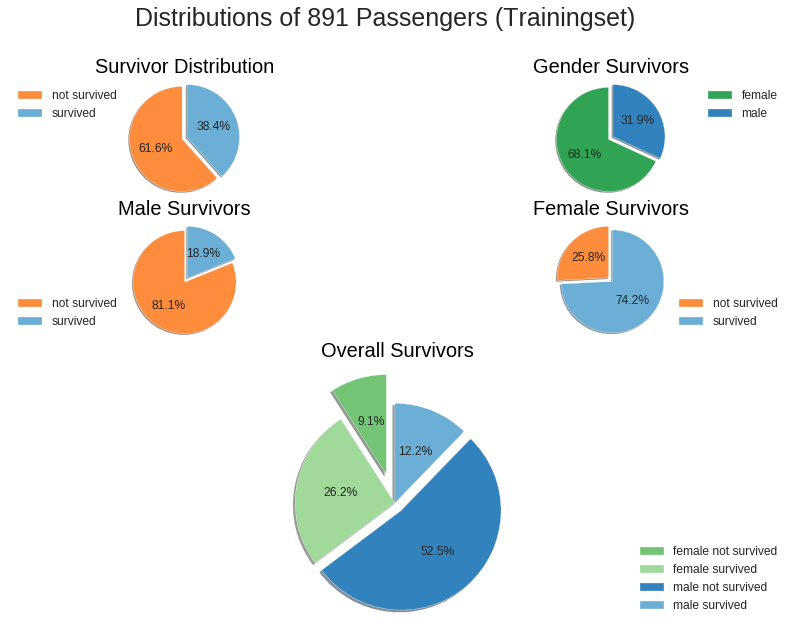

In [70]:
# The dataset with survived information
df_survivalinfo = pd.concat([df_all.loc[train_index,:], Survived], axis=1)

# Survival distribution per Sex
gp_survived_gender = df_survivalinfo.groupby(['Survived','Sex'])['Name'].count()[1]

# Gender Survival
gp_gender_survived = df_survivalinfo.groupby(['Sex','Survived']).count()['Name']

# Survival distribution Y/N 
gp_survived_yn = df_survivalinfo.groupby(['Survived']).agg('count')['Name']

# Survival total female / male 
gp_survival_total = df_survivalinfo.groupby(['Sex','Survived']).count().xs('Name', axis=1)


# Labels and size based on survival group by (df_survivalinfo)
#labels_suvinf = ['not suvived','survived']
sizes_suvinf = [gp_survived_yn[y] for y in range(len(gp_survived_yn))]
explode_suvinf = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

# Labels and size based on gender group by (gp_sex_survived)
labels_sexinf = [gp_survived_gender.index[y] for y in range(len(gp_survived_gender.index))]
sizes_sexinf = [gp_survived_gender[y] for y in range(len(gp_survived_gender))]
explode_sexinf = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

# Labels and size MALE Survivor Distribution
labels_maleinf = [gp_gender_survived['male'].index[y] for y in range(len(gp_gender_survived['male'].index))]
sizes_maleinf = [gp_gender_survived['male'][y] for y in range(len(gp_gender_survived['male']))]
explode_maleinf = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

# Labels and size FEMALE Survivor Distribution
labels_femaleinf = [gp_gender_survived['female'].index[y] for y in range(len(gp_gender_survived['female'].index))]
sizes_femaleinf = [gp_gender_survived['female'][y] for y in range(len(gp_gender_survived['female']))]
explode_femaleinf = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

# Labels and size total survival data
labels_totalsuvinf = [gp_survival_total.index[y] for y in range(len(gp_gender_survived.index))]
sizes_totalsuvinf = [gp_survival_total[y] for y in range(len(gp_survival_total))]
explode_totalsuvinf = (0.3, 0.0, 0.1, 0.0)  # not survived (fm), survived(fm), not survived(m), survived(m)


# Font dictionary
font = {'color':  'black',
        'weight': 'normal',
        #'size': 15,
        'fontsize':15
}

# Color maps for the pies
cmap = plt.get_cmap('tab20c')
survivedcolor = cmap(np.array([5,1]))
survivorallcolor = cmap(np.array([9,10,0,1]))

# Figure and axes of the plot / 4 * 2 plots 
gridsize = (4,2)
fig1 = plt.figure(figsize=(14,10))
ax1 = plt.subplot2grid(gridsize, (0,0))
ax2 = plt.subplot2grid(gridsize, (0,1))
ax3 = plt.subplot2grid(gridsize, (1,0))
ax4 = plt.subplot2grid(gridsize, (1,1))
ax5 = plt.subplot2grid(gridsize, (2,0), colspan= 2, rowspan= 2)

## fig1 configs
fig1.suptitle('Distributions of 891 Passengers (Trainingset)', fontsize=25)

## ax1 
# Define first pie for survival true falls
ax1.pie(sizes_suvinf, 
        explode=explode_suvinf,
        #labels=labels_suvinf,
        autopct='%1.1f%%',
        shadow=True, startangle=90,
        colors=survivedcolor,
        labeldistance=1.15,
        pctdistance=0.55
       )
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#ax1.fontdict=font
ax1.legend(loc='upper left',fontsize='12',labels=('not survived', 'survived'))
ax1.set_title('Survivor Distribution', fontdict=font, fontsize=20)

## ax2 
# Define second pie for sex to survival
ax2.pie(sizes_sexinf, 
        explode=explode_sexinf,
        #labels=labels_sexinf,
        autopct='%1.1f%%',
        shadow=True, startangle=90,
        colors=outer_colors,
        labeldistance=1.15,
        pctdistance=0.55)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#ax2.fontdict=font
ax2.legend(loc='upper right', fontsize='12', labels=labels_sexinf )
ax2.set_title('Gender Survivors', fontdict=font, fontsize=20)

ax3.pie(sizes_maleinf, 
        explode=explode_maleinf,
        #labels=labels_sexinf,
        autopct='%1.1f%%',
        shadow=True, startangle=90,
        colors=survivedcolor,
        labeldistance=1.15,
        pctdistance=0.55)
#ax3.fontdict=font
ax3.legend(loc='lower left', fontsize='12', labels=['not survived','survived'] )
ax3.set_title('Male Survivors', fontdict=font, fontsize=20)
ax3.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


ax4.pie(sizes_femaleinf, 
        explode=explode_femaleinf,
        #labels=labels_sexinf,
        autopct='%1.1f%%',
        shadow=True, startangle=90,
        colors=survivedcolor,
        labeldistance=1.15,
        pctdistance=0.55)
#ax4.fontdict=font
ax4.legend(loc='lower right', fontsize='12', labels=['not survived','survived'] )
ax4.set_title('Female Survivors', fontdict=font, fontsize=20)
ax4.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


ax5.pie(sizes_totalsuvinf, 
        explode=explode_totalsuvinf,
        #labels=labels_totalsuvinf,
        autopct='%1.1f%%',
        shadow=True, startangle=90,
        colors=survivorallcolor,
        labeldistance=1.15,
        pctdistance=0.55)
ax5.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#ax4.fontdict=font
ax5.legend(loc='lower right', fontsize='12', labels=['female not survived','female survived','male not survived','male survived'] )
ax5.set_title('Overall Survivors', fontdict=font, fontsize=20)
ax5.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In total of the 891 passenger informations are 62% that did not made it out of the tragedy and died in the open water.  These survivors are divided into 68.1% women and 31.9% man. It is clearly visible that a lot of female passengers have been rescued. If we look closer into the male passengers data (third pie chart: "Male Survivors), 81% of the male passengers did not survive. In conctract, 74% female passengers survived. That's according to the gentleman's behavior of that time. This situation is best described by a quote of sir ....


68% man and 32% women. So at least a lot of male passengers on board. 




## Distribution of  Ticket Class to Survival


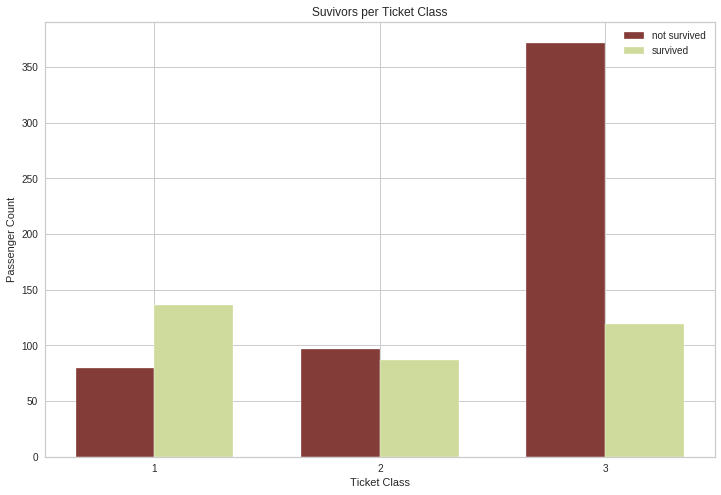

In [71]:
# Grouped by Survived and Pclass
gp_survpclass = df_survivalinfo.groupby(['Survived','Pclass'])['Name'].count()

gridsize = (1,2)
fig1 = plt.figure(figsize=(12,8))
ax1 = plt.subplot2grid(gridsize, (0,0), colspan=2, rowspan=1)

# Bar chart design
bar_width = 0.35
cmap = plt.get_cmap('tab20b')

survbarcol = cmap(np.array([7]))
nsurvbarcol = cmap(np.array([12]))

barindex = gp_survpclass[0].index   # Group by index of bar plot data
xtickslables = [barindex[y] for y in range(len(gp_survpclass[0].index))]



ax1.bar(barindex
        ,gp_survpclass[0].values
        ,bar_width
        ,color=nsurvbarcol
        )

ax1.bar(barindex + bar_width
        ,gp_survpclass[1].values
        ,bar_width
        ,color=survbarcol)

ax1.set_xlabel('Ticket Class')
ax1.set_ylabel('Passenger Count')
ax1.set_title('Suvivors per Ticket Class')
ax1.set_xticks(barindex + bar_width / 2)
ax1.set_xticklabels(xtickslables)
ax1.legend(labels=('not survived','survived'))

fig.tight_layout()
plt.show()

In [72]:
ptbl = pd.DataFrame.pivot_table(df_survivalinfo, values=['Fare', 'Survived'], index=['Pclass'],
                     aggfunc={'Survived': ['sum'], 'Fare': [min,max,np.mean]})

ptbl


Fare                 Survived
             max       mean  min      sum
Pclass                                   
1       512.3292  84.154687  0.0      136
2        73.5000  20.662183  0.0       87
3        69.5500  13.675550  0.0      119

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


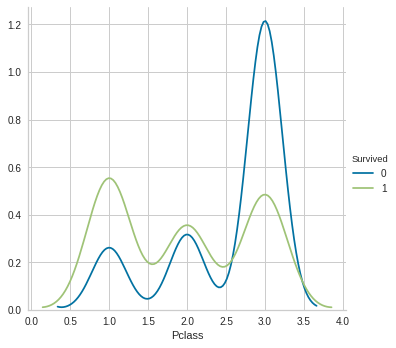

In [73]:
# seaborn's kdeplot, plots univariate or bivariate density estimates.
#Size can be changed by tweeking the value used
sns.FacetGrid(df_survivalinfo.loc[:,['Survived','Pclass']], hue="Survived", height=5).map(sns.kdeplot, "Pclass").add_legend()
plt.show()

## Survivors by Salutation

In [74]:
# Group by salutation and survival
df_survival_sal = df_survivalinfo.groupby(['Salutation','Survived'], as_index=False)['Name'].count()

# Rename column
df_survival_sal = df_survival_sal.rename(columns={"Name": "Total"})

# Aggregate/Count all Salutations
df_survival_sal_total = df_survival_sal.groupby('Salutation', as_index=False)['Total'].agg(sum)

# Not survived Salutations incl. renaming of Total column for join
df_survival_sal_nsuv = pd.DataFrame(df_survival_sal[df_survival_sal['Survived'] == 0])
df_survival_sal_nsuv = df_survival_sal_nsuv.rename(columns={'Total':'Total_notSurvived'})
df_survival_sal_nsuv = df_survival_sal_nsuv[['Salutation','Total_notSurvived']]


# Survived salutations incl. renaming of Total column for join
df_survival_sal_suv = pd.DataFrame(df_survival_sal[df_survival_sal['Survived'] == 1])
df_survival_sal_suv = df_survival_sal_suv.rename(columns={'Total':'Total_Survived'})
df_survival_sal_suv = df_survival_sal_suv[['Salutation','Total_Survived']]

# Joining all salutation survival information together
df_survival_sal_total = df_survival_sal_total.join(df_survival_sal_suv.set_index('Salutation'), on='Salutation', how='outer')
df_survival_sal_total = df_survival_sal_total.join(df_survival_sal_nsuv.set_index('Salutation'), on='Salutation', how='outer')

# Fill the NaN with zeros
df_survival_sal_total = df_survival_sal_total.fillna(value=0)

df_survival_sal_total

,Salutation,Total,Total_Survived,Total_notSurvived
0,Capt.,1,0.0,1.0
1,Col.,2,1.0,1.0
2,Countess.,1,1.0,0.0
3,Don.,1,0.0,1.0
4,Dr.,7,3.0,4.0
5,Jonkheer.,1,0.0,1.0
6,Lady.,1,1.0,0.0
7,Major.,2,1.0,1.0
8,Master.,40,23.0,17.0
9,Miss.,182,127.0,55.0


Here we see the distribution of the Salutation based on its total count and how its distribution according to the survived ones and not survived ones. This will partly visualized in the following chart.

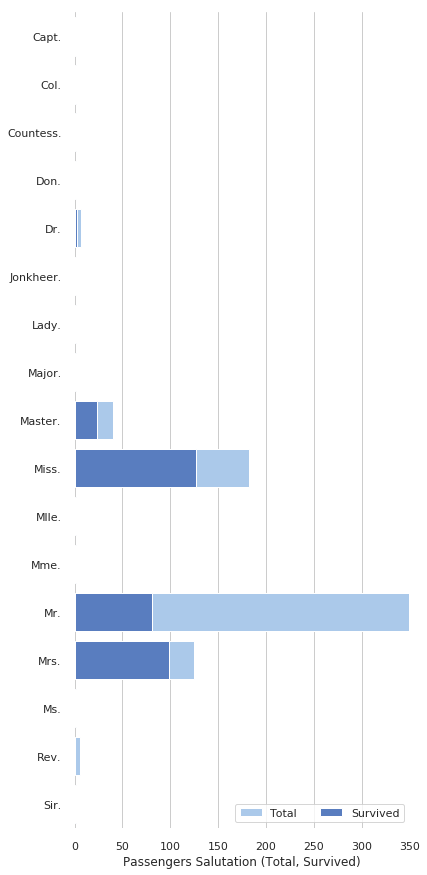

In [75]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Load the example car crash dataset
#crashes = sns.load_dataset("car_crashes").sort_values("total", ascending=False)
salutations = df_survival_sal_total

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="Total", y="Salutation", data=salutations,
            label="Total", color="b")

## Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="Total_Survived", y="Salutation", data=salutations,
            label="Survived", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 350), ylabel="",
       xlabel="Passengers Salutation (Total, Survived)")
sns.despine(left=True, bottom=True)

We can see there are a lot of passengers with the salutation Mr/Mrs (of course), therefore the other ones look quite small or even barely visible through a bar. The light blue bars show the total amount of passengers for the salutation and the dark blue ones show the amount of surviving ones. The “Mr.” has got a lot of loss, the “Miss.” in comparison were luckier. If we look at the dark blue bars and compare “Mr.” and “Mrs.”, it seems there aren't much more “Mrs.” that survived than the “Mr.”. This is deceptive, because not all "Mr." where actually counted for the "Mr." value. Think of "Dr." or "Rev.", these are all salutations that normaly refer to the title "Mr.".

## Family Survival


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


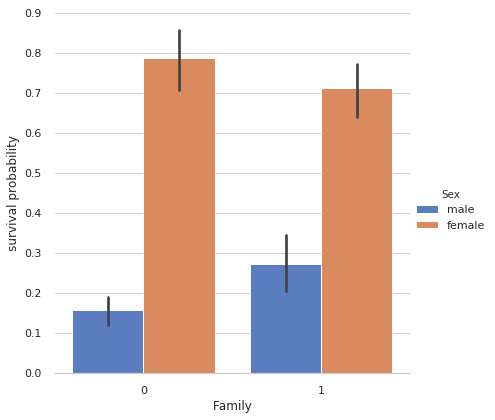

In [76]:
sns.set(style="whitegrid")

# Draw a nested barplot to show survival for class and sex
g = sns.catplot(x="Family", y="Survived", hue="Sex", data=df_survivalinfo,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")

## Gaussian distrbution for age and fare price zu survived = 1 ????

https://matplotlib.org/gallery/statistics/histogram_multihist.html#sphx-glr-gallery-statistics-histogram-multihist-py

In [77]:
fare_survived = df_survivalinfo[df_survivalinfo['Survived'] == 1]['Fare']
fare_survived = df_survivalinfo['Fare']

fare_survived.describe()['mean']
fare_survived.describe()['std']

fare_survived.describe()
fare_survived.values

age_survived = df_survivalinfo['Age']

fare_survived

PassengerId
1        7.2500
2       71.2833
3        7.9250
4       53.1000
5        8.0500
6        8.4583
7       51.8625
8       21.0750
9       11.1333
10      30.0708
11      16.7000
12      26.5500
13       8.0500
14      31.2750
15       7.8542
16      16.0000
17      29.1250
18      13.0000
19      18.0000
20       7.2250
21      26.0000
22      13.0000
23       8.0292
24      35.5000
25      21.0750
26      31.3875
27       7.2250
28     263.0000
29       7.8792
30       7.8958
         ...   
862     11.5000
863     25.9292
864     69.5500
865     13.0000
866     13.0000
867     13.8583
868     50.4958
869      9.5000
870     11.1333
871      7.8958
872     52.5542
873      5.0000
874      9.0000
875     24.0000
876      7.2250
877      9.8458
878      7.8958
879      7.8958
880     83.1583
881     26.0000
882      7.8958
883     10.5167
884     10.5000
885      7.0500
886     29.1250
887     13.0000
888     30.0000
889     23.4500
890     30.0000
891      7.7500
Name: Fare, 

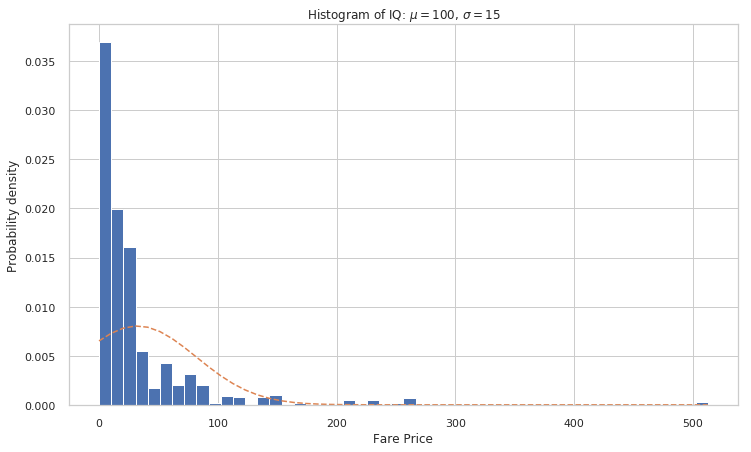

In [78]:
inputfeature = fare_survived

mu = inputfeature.describe()['mean']  # mean of distribution
sigma = inputfeature.describe()['std']  # standard deviation of distribution
x = mu + sigma * inputfeature.values

num_bins = 50

fig, ax = plt.subplots(figsize=(12,7))

# the histogram of the data
n, bins, patches = ax.hist(inputfeature,num_bins, density=1)

# add a 'best fit' line
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')
ax.set_xlabel('Fare Price')
ax.set_ylabel('Probability density')
ax.set_title(r'Histogram of IQ: $\mu=100$, $\sigma=15$')

# Tweak spacing to prevent clipping of ylabel
#fig.tight_layout()
plt.show()

In [79]:
df_survivalinfo[df_survivalinfo['Survived'] == 1].describe()

,Pclass,Age,SibSp,Parch,Fare,Family,Survived
count,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.0
mean,1.950292,28.466871,0.473684,0.464912,48.395408,0.523392,1.0
std,0.863321,13.972759,0.708688,0.771712,66.596998,0.500184,0.0
min,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,1.0
25%,1.000000,21.000000,0.000000,0.000000,12.475000,0.000000,1.0
50%,2.000000,27.000000,0.000000,0.000000,26.000000,1.000000,1.0
75%,3.000000,36.750000,1.000000,1.000000,57.000000,1.000000,1.0
max,3.000000,80.000000,4.000000,5.000000,512.329200,1.000000,1.0


## Survivor by Fare Price ???


In [80]:
# Pivot for age and fare
ptbl_survived = pd.DataFrame.pivot_table(df_survivalinfo, values=['Fare', 'Age', 'Survived'], index=['Sex', 'Pclass'],
                     aggfunc={'Fare': np.mean,'Age': [min, max, np.mean], 'Survived': ['sum']})
ptbl_survived

Age                         Fare Survived
                max       mean   min        mean      sum
Sex    Pclass                                            
female 1       63.0  35.031915  2.00  106.125798       91
       2       57.0  28.756579  2.00   21.970121       70
       3       63.0  22.697917  0.75   16.118810       72
male   1       80.0  40.888689  0.92   67.226127       45
       2       70.0  30.678981  0.67   19.741782       17
       3       74.0  26.099193  0.42   12.661633       47

## Overall Bivariate Relation

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


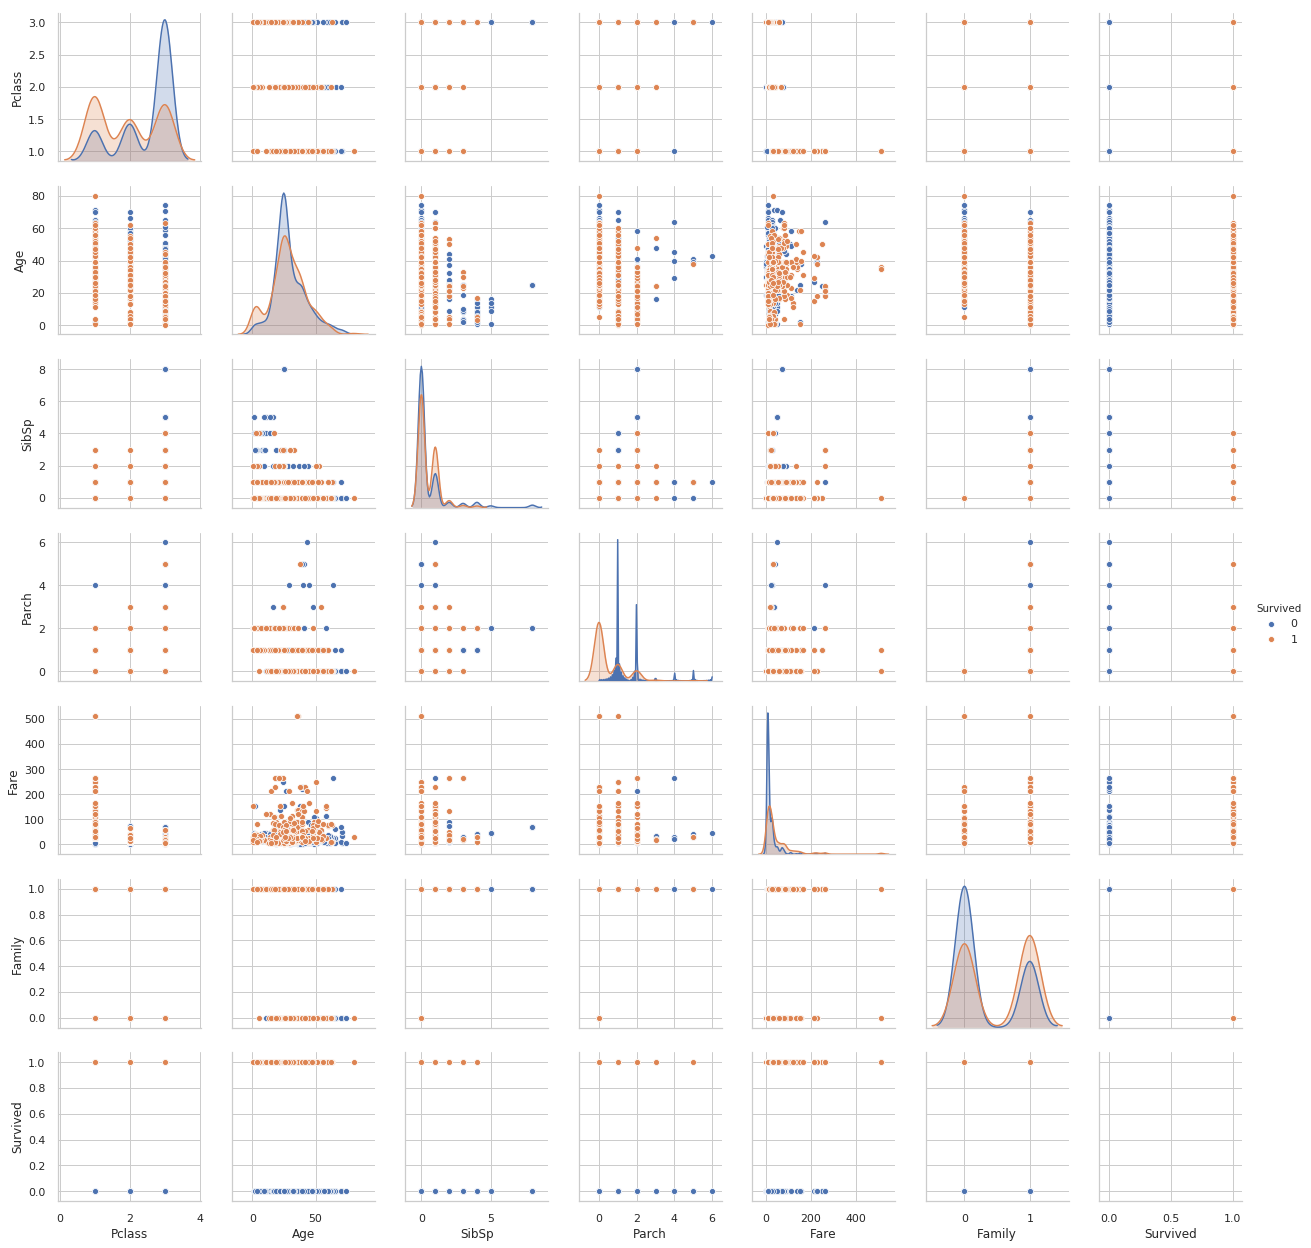

In [81]:
sns.pairplot(df_survivalinfo, hue='Survived')

# Model and Prediction

In [111]:
# Using here the full dataset because train and test set must have the same shape when using it with model

# One hot encoding for the categorical data
df_all_hot = df_all.copy()
df_all_hot = df_all_hot.drop(['Name','Cabin','Ticket'], axis=1)
df_all_hot = pd.get_dummies(df_all_hot, columns=['Sex','Salutation','Embarked'])
#df_all_hot


# Train test split only on test dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_all_hot.loc[train_index,:], Survived, test_size = 0.20, random_state = 25)  ## 50  25 ## 0.25 25

## Visualize the Best Model Fit

In [112]:
from sklearn.model_selection import cross_val_score

# creating odd list of K for KNN
myList = list(range(1,50))

# subsetting just the odd ones
neighbors = list(myList)


# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

The optimal number of neighbors is 1


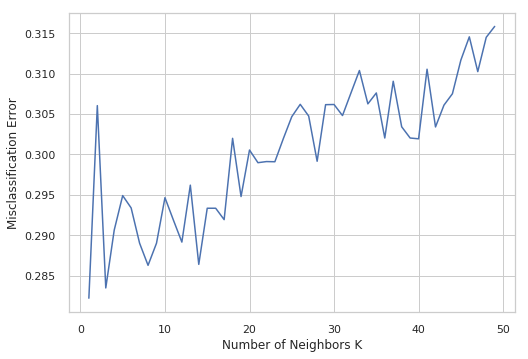

In [113]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print ("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

## Training
The previous shown optimal number of neighbors (**3**) will now be used to build the prediction model.

In [114]:
# K-Nearest Neighbours
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


X_train = X_train
y_train = y_train

# 3 Neighbors used from the misclassification error calculation
KNNC = KNeighborsClassifier(n_neighbors=3)
KNNC.fit(X_train, y_train)

y_pred = KNNC.predict(X_test)

# Summary of the predictions made by the classifier
print(classification_report(y_test, y_pred, target_names=['0','1']))

print('accuracy is',accuracy_score(y_pred,y_test))

print ("Models accuracy score: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.79      0.81       112
           1       0.67      0.70      0.69        67

   micro avg       0.76      0.76      0.76       179
   macro avg       0.74      0.75      0.75       179
weighted avg       0.76      0.76      0.76       179

accuracy is 0.7597765363128491
Models accuracy score:  0.7597765363128491


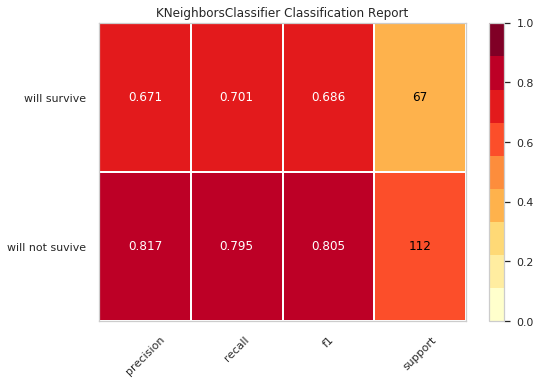

In [115]:
from yellowbrick.classifier import ClassificationReport

classes = ["will not suvive", "will survive"]

# Instantiate the classification model and visualizer
visualizer = ClassificationReport(KNNC, classes=classes, support=True)

visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

## Execution on Testset
...